In [1]:
!pip install pandas numpy matplotlib boto3 s3fs

In [5]:
# This makes sure you’re invoking pip for the exact Python your notebook is running
import sys
!{sys.executable} -m pip install --upgrade "s3fs>=2023.11.1"


  Attempting uninstall: fsspec
    Found existing installation: fsspec 2025.2.0
    Uninstalling fsspec-2025.2.0:
      Successfully uninstalled fsspec-2025.2.0
  Attempting uninstall: s3fs
    Found existing installation: s3fs 0.4.2
    Uninstalling s3fs-0.4.2:
      Successfully uninstalled s3fs-0.4.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2025.2.0 requires fsspec==2025.2.0, but you have fsspec 2025.3.2 which is incompatible.
s3contents 0.6.0 requires s3fs<0.5.1,>=0.3.4, but you have s3fs 2025.3.2 which is incompatible.


In [1]:

import boto3
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import io, csv


In [2]:
# 2) Read “processed” CSV parts from S3 into pandas
s3 = boto3.client("s3")

In [6]:
# 3) Point pandas at your S3 URLs
ratings_df = pd.read_csv(
    "s3://recomendandoando/processed/clean/ratings/ratings_filtered.csv"
)
movies_df = pd.read_csv(
    "s3://recomendandoando/processed/clean/movies/movies_filtered.csv",
    sep=",",
    engine="python",                # use Python parser
    quotechar='"',                  # fields are wrapped in double quotes
    quoting=csv.QUOTE_MINIMAL,      # only quote when necessary
    on_bad_lines="skip",            # drop any truly malformed lines
    skipinitialspace=True           # trim spaces after delimiter
)


# 4) Quick sanity check
print("Ratings:", ratings_df.shape)
print("Movies: ", movies_df.shape)
ratings_df.head(), movies_df.head()

Ratings: (31901794, 4)
Movies:  (87158, 3)


(   movieId  userId  rating  timestamp
 0       17       1     4.0  944249077
 1       25       1     1.0  944250228
 2       29       1     2.0  943230976
 3       30       1     5.0  944249077
 4       32       1     5.0  943228858,
    movieId                               title  \
 0        1                    Toy Story (1995)   
 1        2                      Jumanji (1995)   
 2        3             Grumpier Old Men (1995)   
 3        4            Waiting to Exhale (1995)   
 4        5  Father of the Bride Part II (1995)   
 
                                         genres  
 0  Adventure|Animation|Children|Comedy|Fantasy  
 1                   Adventure|Children|Fantasy  
 2                               Comedy|Romance  
 3                         Comedy|Drama|Romance  
 4                                       Comedy  )

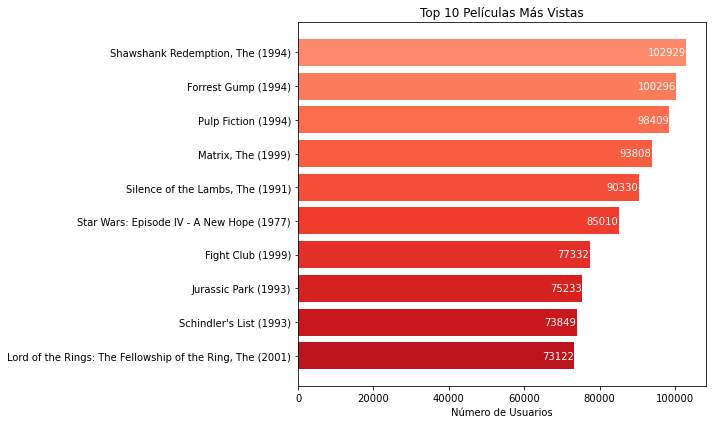

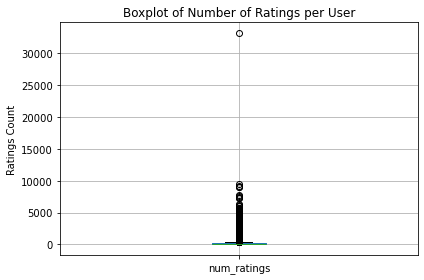

count    200948.000000
mean        158.756464
std         281.148949
min          18.000000
25%          36.000000
50%          72.000000
75%         166.000000
max       33200.000000
Name: num_ratings, dtype: float64


In [7]:
# 3) Compute “Número de Usuarios” per movie
movie_watch_count = (
    ratings_df
      .groupby("movieId")["userId"]
      .nunique()
      .reset_index(name="Número de Usuarios")
      .merge(
         movies_df[["movieId","title"]],
         on="movieId",
         how="left"
      )
)
# 4) Plot top-10 most-watched
top_n = 10
top10 = movie_watch_count.nlargest(top_n, "Número de Usuarios")

plt.figure(figsize=(10,6))
bars = plt.barh(
    top10["title"],
    top10["Número de Usuarios"],
    color=plt.cm.Reds(np.linspace(0.4,0.8,top_n))
)
plt.gca().invert_yaxis()
plt.xlabel("Número de Usuarios")
plt.title(f"Top {top_n} Películas Más Vistas")
for bar in bars:
    plt.text(bar.get_width()-30,
             bar.get_y()+bar.get_height()/2,
             int(bar.get_width()),
             va="center", ha="right", color="white")
plt.tight_layout()
plt.show()


# 5) Compute and boxplot “num_ratings” per user
user_activity = (
    ratings_df
      .groupby("userId")
      .size()
      .reset_index(name="num_ratings")
)

plt.figure(figsize=(6,4))
user_activity.boxplot(column=["num_ratings"])
plt.title("Boxplot of Number of Ratings per User")
plt.ylabel("Ratings Count")
plt.tight_layout()
plt.show()

# 6) Quick describe
print(user_activity["num_ratings"].describe())